# Data Science for Business - Tree-based Models on Micro Mortgages

## Initialize notebook
Load required packages. Set up workspace, e.g., set theme for plotting and initialize the random number generator.

In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, auc
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier


In [2]:
np.random.seed(42)
plt.style.use('fivethirtyeight')

## Problem description

In India, there are about 20 million home loan (mortgage) aspirants
working in the informal sector:

- Monthly income between INR 20,000-25,000 (\$ 325-400)
- Typically no formal accounts and documents (e.g., tax returns, income proofs, bank statements)
- Often use services of money lenders with interest rates between 30 and 60% per annum

Providing mortgages to this group of customers requires to quickly and
efficiently assess their creditworthiness. Due to a lack of formal
documents and objective data, most financial institutions perform
interview-based processes to decide about these loan requests:

Strength of the current process:

-   Interview-based field assessment

-   Relaxation of document requirements

Weaknesses of the current process:

-   Costly (total transaction costs as high as 30% of loan volume)

-   Subjective judgments; depends on individual skills and motivations

-   Low reliability across branches and credit officers

-   Risk of corruption and fraud

## Load data

Load training data from CSV file.

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/olivermueller/ds4b-2024/refs/heads/main/Session_07/micromortgage.csv')

In [4]:
data.head()

,ID,Decision,Build_Selfcon,Tier,Accommodation_Class,Loan_Type,Gender,Employment_Type,Doc_Proof_Inc,Marital_Status,...,LoanReq,Term,Dwnpay,BankSave,CalcEmi,IIR,IAR,FOIR,LTV,LVR
0,FBD-E2B0-588300,1,Self Contruction,2,Non_Rented,Home_Loan,Female,Salaried,N,Married,...,780000,180,670000,0,12004.230470,34.999797,45.000114,34.999797,80.000000,54.000000
1,GUJ-A79X-831476,0,Self Contruction,1,Non_Rented,Home_Loan,Female,Self_Employed,N,Married,...,800000,180,470000,0,12312.030270,49.248121,75.533928,49.248121,62.992126,62.992126
2,SHB-947O-759226,1,Self Contruction,3,Rented,Home_Loan,Female,Salaried,N,Married,...,480000,120,120000,300000,8342.290039,41.999144,79.998946,41.999144,78.999992,80.000000
3,SHB-7S3I-679761,1,Self Contruction,3,Non_Rented,Home_Loan,Female,Self_Employed,N,Married,...,300000,180,95000,0,4617.009766,30.999126,84.996498,30.999126,20.000000,76.000000
4,VAD-BPKZ-551476,0,Self Contruction,2,Non_Rented,Home_Loan,Female,Self_Employed,N,Married,...,1000000,180,375000,0,15390.040040,45.000117,57.999020,45.000117,73.000001,73.000000


## Prepare data

In [5]:
data = data.drop(['ID'], axis=1)
data["Tier"] = data["Tier"].apply(lambda x: "T"+str(x))

In [6]:
X = data.drop("Decision", axis=1)
y = data["Decision"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
categorical_features = X_train.select_dtypes(include='object').columns
numerical_features = X_train.select_dtypes(exclude='object').columns

In [8]:
categorical_features

Index(['Build_Selfcon', 'Tier', 'Accommodation_Class', 'Loan_Type', 'Gender',
       'Employment_Type', 'Doc_Proof_Inc', 'Marital_Status', 'Employer_Type',
       'Education_Class', 'Mode_of_origin_class'],
      dtype='object')

In [9]:
numerical_features

Index(['eom_25', 'OldEmi_d', 'BankSave_d', 'Age', 'YrsAdd', 'YrsJob', 'Expen',
       'TotInc', 'DispInc', 'MarVal', 'OldEmi', 'LoanReq', 'Term', 'Dwnpay',
       'BankSave', 'CalcEmi', 'IIR', 'IAR', 'FOIR', 'LTV', 'LVR'],
      dtype='object')

In [10]:
enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
enc.fit(X_train[categorical_features])

X_train_cat = enc.transform(X_train[categorical_features])
X_test_cat = enc.transform(X_test[categorical_features])

X_train_cat = pd.DataFrame(X_train_cat, columns=enc.get_feature_names_out(categorical_features))
X_test_cat = pd.DataFrame(X_test_cat, columns=enc.get_feature_names_out(categorical_features))

In [11]:
X_train_cat.head()

,Build_Selfcon_Builder,Build_Selfcon_Self Contruction,Tier_T1,Tier_T2,Tier_T3,Accommodation_Class_Non_Rented,Accommodation_Class_Rented,Loan_Type_Home_Improvement,Loan_Type_Home_Loan,Gender_Female,...,Employer_Type_Business,Employer_Type_Corporate,Employer_Type_Govt,Employer_Type_Ind/SmallBus,Education_Class_GRADUATE+,Education_Class_U10,Education_Class_UNDERGRADUATE,Mode_of_origin_class_Others,Mode_of_origin_class_Own database field visit,Mode_of_origin_class_Reference
0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [12]:
scaler = StandardScaler()
scaler.fit(X_train[numerical_features]) 

X_train_num = scaler.transform(X_train[numerical_features])
X_test_num = scaler.transform(X_test[numerical_features])

X_train_num = pd.DataFrame(X_train_num, columns=numerical_features)
X_test_num = pd.DataFrame(X_test_num, columns=numerical_features)

In [13]:
X_train_num.head()

,eom_25,OldEmi_d,BankSave_d,Age,YrsAdd,YrsJob,Expen,TotInc,DispInc,MarVal,...,LoanReq,Term,Dwnpay,BankSave,CalcEmi,IIR,IAR,FOIR,LTV,LVR
0,-0.523557,-0.389071,-0.354345,0.492436,1.452931,1.148835,1.758042,0.636953,-0.003758,0.468872,...,0.911333,0.552998,0.854405,-0.174566,0.787476,-0.607180,0.156632,-0.783101,-0.145868,-0.439966
1,-0.523557,-0.389071,-0.354345,1.080875,-0.838288,-1.119960,-0.663347,-0.405469,-0.199890,0.176403,...,0.567547,0.552998,0.517944,-0.174566,0.437153,1.379933,0.429896,1.167426,-0.055918,-0.349566
2,1.910013,-0.389071,-0.354345,-0.331378,-0.360951,-0.867872,-0.680420,0.432506,0.829239,0.211792,...,1.770797,0.552998,-0.183017,-0.174566,1.663286,0.433728,-0.708569,0.238642,0.843581,0.554433
3,-0.523557,-0.389071,-0.354345,-0.096002,0.498256,0.518614,-0.245413,-0.054211,0.042832,0.040139,...,0.051868,0.552998,1.754439,-0.174566,-0.088331,-0.338312,-0.709183,-0.519184,-0.309925,-0.604844
4,-0.523557,2.570226,-0.354345,0.610124,-0.170016,1.779055,2.001719,0.714879,-0.016972,1.914943,...,1.770797,0.552998,3.097480,-0.174566,1.663286,-0.039460,0.976423,1.594633,-0.730541,-1.027565


In [14]:
X_train = pd.concat([X_train_num, X_train_cat], axis=1)
X_test = pd.concat([X_test_num, X_test_cat], axis=1)

In [15]:
X_train.head()

,eom_25,OldEmi_d,BankSave_d,Age,YrsAdd,YrsJob,Expen,TotInc,DispInc,MarVal,...,Employer_Type_Business,Employer_Type_Corporate,Employer_Type_Govt,Employer_Type_Ind/SmallBus,Education_Class_GRADUATE+,Education_Class_U10,Education_Class_UNDERGRADUATE,Mode_of_origin_class_Others,Mode_of_origin_class_Own database field visit,Mode_of_origin_class_Reference
0,-0.523557,-0.389071,-0.354345,0.492436,1.452931,1.148835,1.758042,0.636953,-0.003758,0.468872,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,-0.523557,-0.389071,-0.354345,1.080875,-0.838288,-1.119960,-0.663347,-0.405469,-0.199890,0.176403,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,1.910013,-0.389071,-0.354345,-0.331378,-0.360951,-0.867872,-0.680420,0.432506,0.829239,0.211792,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,-0.523557,-0.389071,-0.354345,-0.096002,0.498256,0.518614,-0.245413,-0.054211,0.042832,0.040139,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,-0.523557,2.570226,-0.354345,0.610124,-0.170016,1.779055,2.001719,0.714879,-0.016972,1.914943,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


## Classification and Regression Trees (CART)

First, we will grow a single CART tree.

In [16]:
model_cart = DecisionTreeClassifier(criterion='entropy', random_state=42)

In [17]:
model_cart.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

Let's check how well the tree performs on the training and test data.

In [18]:
# Training data
pred_label_train = model_cart.predict(X_train)
pred_proba_train = model_cart.predict_proba(X_train)[:,1]
acc_train = accuracy_score(y_train, pred_label_train)
auc_train = roc_auc_score(y_train, pred_proba_train)
print('ACC on training set:', round(acc_train, 2))
print('AUC on training set:', round(auc_train, 2))

print("===")

# Test data
pred_label_test = model_cart.predict(X_test)
pred_proba_test = model_cart.predict_proba(X_test)[:,1]
acc_test = accuracy_score(y_test, pred_label_test)
auc_test = roc_auc_score(y_test, pred_proba_test)
print('ACC on training set:', round(acc_test, 2))
print('AUC on test set:', round(auc_test, 2))

ACC on training set: 1.0
AUC on training set: 1.0
===
ACC on training set: 0.73
AUC on test set: 0.58


The advantage of a single tree is that it is easy to interpret and visualize. Let's have a look.

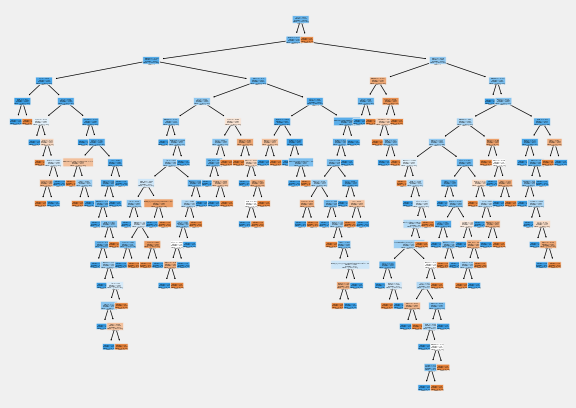

In [19]:
fn = model_cart.feature_names_in_
labels = model_cart.classes_
labels = [str(item) for item in labels]

tree.plot_tree(model_cart, feature_names=fn, class_names=labels, filled=True, proportion=True, rounded=True)
plt.show()

Wow, that's a big tree! It is hard to interpret and understand. Let's go back and try to grow a smaller tree by setting stopping rules (e.g., `max_depth`) or pruning the tree (`ccp_alpha`).

In [20]:
# YOUR CODE HERE

## Random Forest

Let's now try to grow a random forest. This time, we will use hyperparameter tuning with k-fold cross validation to find the best model.

In [21]:
model_rf_cv = lambda: GridSearchCV(
                estimator=RandomForestClassifier(random_state=42),
                param_grid={
                        'n_estimators': [100, 200, 300],
                        'max_depth': [3, 5, None],
                        'min_samples_leaf': [2, 5, 10]
                    }, cv=5, n_jobs=-1
                )

In [22]:
model_rf_tuned = model_rf_cv()
model_rf_tuned.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, None],
                         'min_samples_leaf': [2, 5, 10],
                         'n_estimators': [100, 200, 300]})

Make predictions on test set and evaluate the model.

In [23]:
rf_pred_label = model_rf_tuned.predict(X_test)
rf_pred_proba = model_rf_tuned.predict_proba(X_test)[:,1]

In [24]:
print(classification_report(y_test, rf_pred_label))

              precision    recall  f1-score   support

           0       1.00      0.31      0.47        55
           1       0.84      1.00      0.91       197

    accuracy                           0.85       252
   macro avg       0.92      0.65      0.69       252
weighted avg       0.87      0.85      0.82       252



Plot the ROC curve and calculate the AUC.

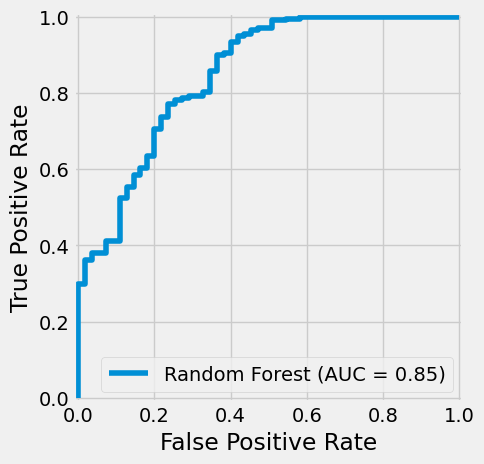

In [25]:
fpr, tpr, thresholds = roc_curve(y_test, rf_pred_proba)
auc_score = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_score, estimator_name='Random Forest')
display.plot()
plt.show()

In [26]:
roc_auc_score(y_test, rf_pred_proba)

0.8487309644670051

## Boosted Trees

Finally, we will try boosted trees. We will use the fast `HistGradientBoostingClassifier` (Histogram-based Gradient Boosting Classification Tree) learner, which is inspired by the LightGBM algorithm. Again, we will use hyperparameter tuning with k-fold cross validation to find the best model.

In [27]:
model_boost_cv = lambda: GridSearchCV(
                estimator=HistGradientBoostingClassifier(random_state=42),
                param_grid={
                        'max_iter': [100, 200],
                        'max_depth': [1, 3]
                    }, cv=5, n_jobs=-1
                )

In [28]:
model_boost_tuned = model_boost_cv()
model_boost_tuned.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=HistGradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [1, 3], 'max_iter': [100, 200]})

In [29]:
model_boost_tuned.best_estimator_

HistGradientBoostingClassifier(max_depth=3, random_state=42)

In [30]:
boost_pred_label = model_boost_tuned.predict(X_test)
boost_pred_proba = model_boost_tuned.predict_proba(X_test)[:,1]

In [31]:
print(classification_report(y_test, boost_pred_label))

              precision    recall  f1-score   support

           0       0.80      0.44      0.56        55
           1       0.86      0.97      0.91       197

    accuracy                           0.85       252
   macro avg       0.83      0.70      0.74       252
weighted avg       0.85      0.85      0.84       252



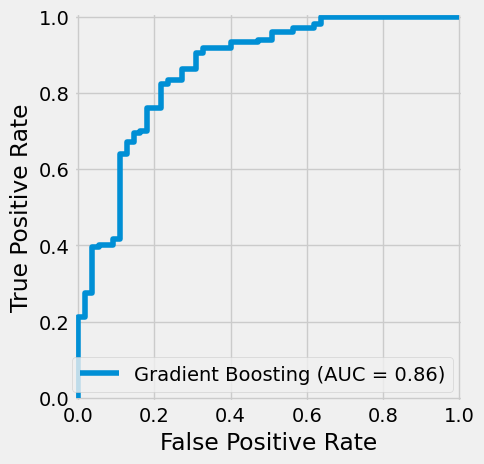

In [32]:
fpr, tpr, thresholds = roc_curve(y_test, boost_pred_proba)
auc_score = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_score, estimator_name='Gradient Boosting')
display.plot()
plt.show()

In [33]:
roc_auc_score(y_test, boost_pred_proba)

0.8636825103830179

## Your Turn!

We did only a minimal amount of hyperparameter tuning. Try to improve the Boosted Trees model by extending the search space (i.e., more hyperparameters and more candidate values per hyperparameter).